# **CLUSTERING**

***Clustering*** is an unsupervised learning technique in ML that aims to **separate population or data point into groups that consist of similar charateristic**.



Some use cases on clustering implementation:
- Customer Segmentation:
    - demographic, geographic, psychographic, behavioral
- Document Clustering:
    - Grouping article based on their content, efficiently organize or retrieve similar document.
- Market Basket Analysis:
    - Grouping items based on co-occurence purchasing patterns, e.g:frequently bought together, cross-sale opportunity

# **USE CASE EXAMPLE: GEOLOCATION DATA**

*Context:*

A company wants to expand to California because there has been a trend of increasing demand in the area in recent times, but the company has not yet invested much in there.

Currently, the company plans to set up several inventory points to supply the needs of the region.

Here, you are provided with the shipping address data from customer transactions that occurred over the past 2 years.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import geopandas as gpd
import shapely
from sklearn.datasets import fetch_california_housing
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

In [2]:
data = fetch_california_housing(as_frame=True).frame[['Longitude','Latitude']]
data = data.sample(15000,random_state=0).reset_index(drop=True)
data.head()

,Longitude,Latitude
0,-117.05,32.58
1,-117.97,33.92
2,-121.84,38.65
3,-115.60,33.20
4,-122.43,37.79


Each row represent 1 transaction.

Let's say in row 0 there is customer A who bought several items and it send into those longitude and latitude address.

In [3]:
# Create a geometry column based on longitude and latitude
geometry = [shapely.geometry.Point(xy) for xy in zip(data['Longitude'], data['Latitude'])]
geo_df = gpd.GeoDataFrame(data, geometry=geometry)
# Set the correct CRS (Coordinate Reference System)
geo_df.crs = "EPSG:4326" 

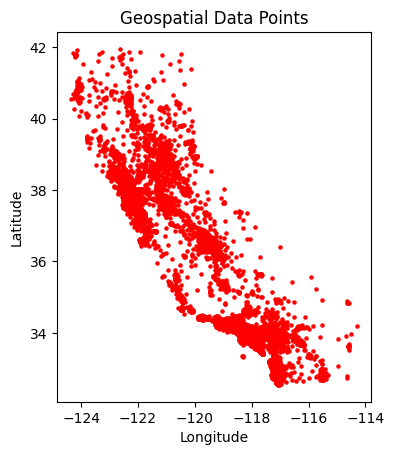

In [4]:
# Plot the points on a map
geo_df.plot(marker='o', color='red', markersize=5)
# Optionally, add a base map or other enhancements
plt.title('Geospatial Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

1 dots represent 1 row, or 1 transaction.

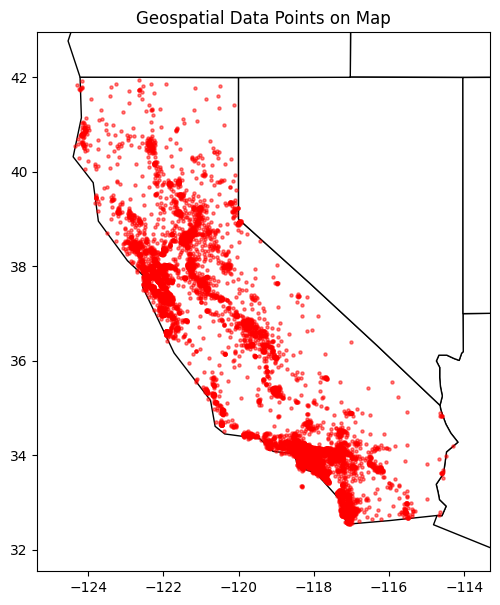

In [5]:
# Load a shapefile (e.g., countries map) for a basemap
# world = gpd.read_file(r"ne_110m_admin_0_countries\\ne_110m_admin_0_countries.shp")
world = gpd.read_file(r"ne_110m_admin_1_states_provinces\\ne_110m_admin_1_states_provinces.shp")
# Plot the basemap and overlay your points
fig, ax = plt.subplots(figsize=(7, 7))
world.plot(ax=ax, color='white', edgecolor='black')  # Plot world map
geo_df.plot(ax=ax, marker='o', color='red', markersize=5, alpha=.5)  # Overlay points

# # Set the axis limits to zoom in on the area around the data points
# Calculate the min and max of the longitude and latitude for your data points
min_lon, max_lon = geo_df['Longitude'].min() - 1, geo_df['Longitude'].max() + 1
min_lat, max_lat = geo_df['Latitude'].min() - 1, geo_df['Latitude'].max() + 1
# Adjust the axis limits for zooming
ax.set_xlim(min_lon, max_lon)  # Set longitude range
ax.set_ylim(min_lat, max_lat)  # Set latitude range

plt.title('Geospatial Data Points on Map')
plt.show()

In [6]:
def kmeans_n(n_clust):
    df_clust = geo_df.copy()
    model = KMeans(n_clusters=n_clust, algorithm='elkan',random_state=0)
    df_clust['cluster'] = model.fit_predict(df_clust[['Longitude','Latitude']])

    world = gpd.read_file(r"ne_110m_admin_1_states_provinces\\ne_110m_admin_1_states_provinces.shp")
    # Plot the basemap and overlay your points
    fig, ax = plt.subplots(figsize=(5,5))
    world.plot(ax=ax, color='white', edgecolor='black')  # Plot world map
    df_clust.plot(ax=ax, column='cluster', cmap='Accent', legend=True,
            marker='o', markersize=5, alpha=.5)  # Overlay points
    unique_clusters = df_clust['cluster'].unique()
    # Create color-to-cluster mappings using the same colormap
    # for cluster in unique_clusters:
    #     color = plt.cm.Accent(cluster*2)  # Map the cluster to a color in the colormap
    #     ax.scatter([], [], color=color, label=f'Cluster {cluster}', marker='o', s=60) 

    sns.scatterplot(data=pd.DataFrame(model.cluster_centers_),x=0,y=1,
                    marker='s',color='red',legend=True)

    # # Set the axis limits to zoom in on the area around the data points
    # Calculate the min and max of the longitude and latitude for your data points
    min_lon, max_lon = df_clust['Longitude'].min() - 1, df_clust['Longitude'].max() + 1
    min_lat, max_lat = df_clust['Latitude'].min() - 1, df_clust['Latitude'].max() + 1
    # Adjust the axis limits for zooming
    ax.set_xlim(min_lon, max_lon)  # Set longitude range
    ax.set_ylim(min_lat, max_lat)  # Set latitude range

    plt.title('Geospatial Data Points on Map')
    plt.show()

    display(pd.DataFrame(round(df_clust.cluster.value_counts(normalize=True)*100,2)))

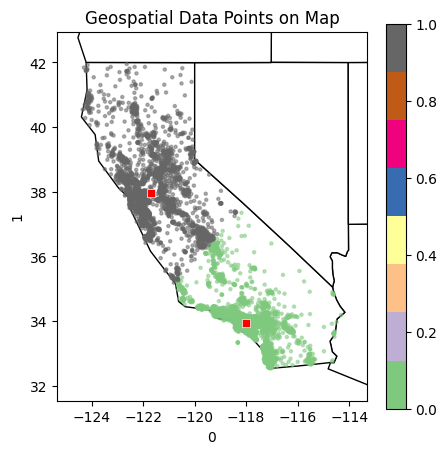

,proportion
cluster,
0,58.05
1,41.95


In [7]:
kmeans_n(n_clust=2)

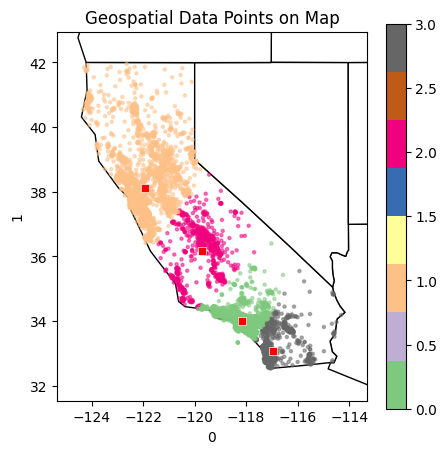

,proportion
cluster,
0,43.65
1,37.11
3,10.61
2,8.63


In [8]:
kmeans_n(n_clust=4)

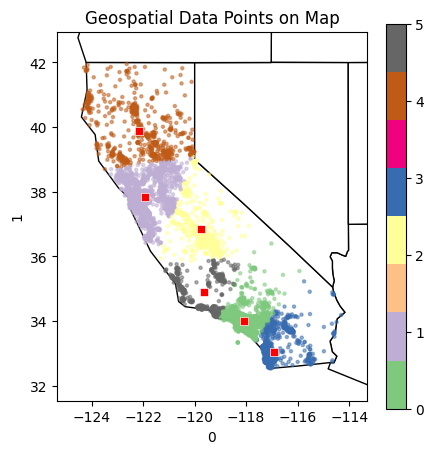

,proportion
cluster,
0,42.10
1,31.27
3,10.31
2,6.19
4,5.15
5,4.97


In [9]:
kmeans_n(n_clust=6)

In [10]:
def gmm_clust(n_clust):
    df_clust = geo_df.copy()
    model = GaussianMixture(n_components=n_clust,covariance_type='full',
                            tol=0.1,reg_covar=0.0001,random_state=0)
    df_clust['cluster'] = model.fit_predict(df_clust[['Longitude','Latitude']])

    world = gpd.read_file(r"ne_110m_admin_1_states_provinces\\ne_110m_admin_1_states_provinces.shp")
    # Plot the basemap and overlay your points
    fig, ax = plt.subplots(figsize=(5,5))
    world.plot(ax=ax, color='white', edgecolor='black')  # Plot world map
    df_clust.plot(ax=ax, column='cluster', cmap='Accent', legend=True,
            marker='o', markersize=5, alpha=.5)  # Overlay points
    sns.scatterplot(data=pd.DataFrame(model.means_),x=0,y=1,
                    marker='s',color='red')

    # # Set the axis limits to zoom in on the area around the data points
    # Calculate the min and max of the longitude and latitude for your data points
    min_lon, max_lon = df_clust['Longitude'].min() - 1, df_clust['Longitude'].max() + 1
    min_lat, max_lat = df_clust['Latitude'].min() - 1, df_clust['Latitude'].max() + 1
    # Adjust the axis limits for zooming
    ax.set_xlim(min_lon, max_lon)  # Set longitude range
    ax.set_ylim(min_lat, max_lat)  # Set latitude range

    plt.title('Geospatial Data Points on Map')
    plt.show()

    display(pd.DataFrame(round(df_clust.cluster.value_counts(normalize=True)*100,2)))

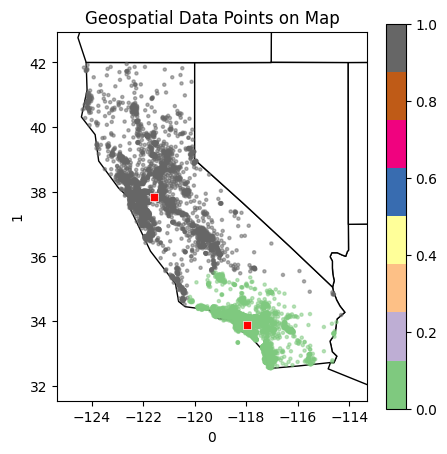

,proportion
cluster,
0,55.56
1,44.44


In [11]:
gmm_clust(n_clust=2)

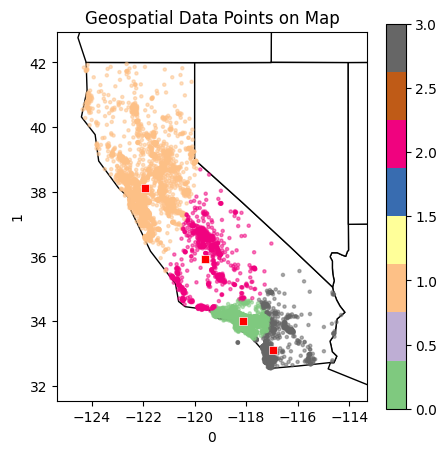

,proportion
cluster,
0,41.91
1,37.65
3,10.85
2,9.59


In [12]:
gmm_clust(n_clust=4)

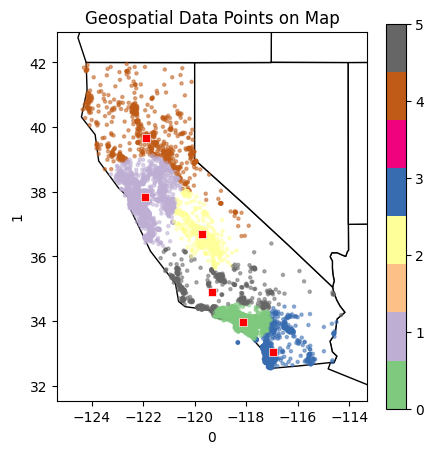

,proportion
cluster,
0,41.55
1,31.37
3,10.12
4,5.69
5,5.67
2,5.60


In [13]:
gmm_clust(n_clust=6)